In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

C:\Users\USER\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Init

In [48]:
from transformers import BertTokenizer, BertModel, BertConfig

device = "cuda" if torch.cuda.is_available() else "cpu"
configuration = BertConfig()
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
args = {
        "device" : device,
        "data_dir" : r'../data/filtered_reviews_with_split.pkl',
        "data_chunks_dir" : r'../data/chunks',
        "emb_dim" : 768,
        "max_word" : 25,
        "max_sentence" : 10,
        "max_group": 5, # exclude default group
        "max_review_user" : 20,
        "max_review_item" : 50,
        "epoch" : 5,
        "batch_size": 32,
        "bert_configuration" : configuration,
        "bert_model" : bert_model,
        "bert_tokenizer" : bert_tokenizer
    }

print("Device: ",device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device:  cuda


## Read Pickle

In [49]:
"""
Required dataframe format:
[column name]       [dtype]
AppID               int
UserID              int
Like                int
Review              String
"""
data = pd.read_pickle(r'../data/reviews_30886.pkl')
# Change dtype of columns in df
data.reset_index(drop=True, inplace=True)
data["UserID"] = data["UserID"].astype("int64")
data["AppID"] = data["AppID"].astype(int)
data["Like"] = data["Like"].astype(int)
"""
TODO dataframe format:
[column name]       [dtype]
SplitReview         list
LDA_group           list
SplitReview_emb     np.array
"""
# TODO Columns
data["SplitReview"] = ""
data["SplitReview_emb"]= ""
data["LDA_group"]= ""

print(data.dtypes)
print("---Once you've prepared the data, press {Run All} will do the rest---")
data

AppID               int32
UserID              int64
Like                int32
Review             object
SplitReview        object
SplitReview_emb    object
LDA_group          object
dtype: object
---Once you've prepared the data, press {Run All} will do the rest---


,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,730,76561197969379991,1,wingman is fun with friends.,,,
1,730,76561198118543045,0,"Awful, toxic community and annoying game play....",,,
2,730,76561197971801273,0,After playing Counterstrike: Source for 12000+...,,,
3,730,76561198123845513,0,[h1] This really doesn't have the feel of spor...,,,
4,730,76561198066952727,0,too many inconsistencies to make this a good c...,,,
...,...,...,...,...,...,...,...
30881,9160,76561197964009814,0,The most demonic and difficult user made level...,,,
30882,9160,76561197977081885,1,"More like, Masturbator Levels of Doom 2 AMIRIT...",,,
30883,9160,76561197993676094,1,Just some random lvls,,,
30884,9160,76561198010396848,1,additional levels for Doom 2.,,,


# Filter data

In [50]:
# check the number of reviews for each user/item 
app_reviews = data['AppID'].value_counts()
user_reviews = data['UserID'].value_counts()
app_reviews, user_reviews

(379720    313
 8870      270
 108710    248
 204100    216
 233270    210
          ... 
 46500      34
 540840     34
 857980     34
 557600     34
 388210     34
 Name: AppID, Length: 428, dtype: int64,
 76561198046675266    186
 76561198062813911    179
 76561198161141911    140
 76561197970705552    124
 76561198093363183    120
                     ... 
 76561197997195660     30
 76561198357383191     30
 76561198062363150     30
 76561198203292090     30
 76561198160445380     30
 Name: UserID, Length: 708, dtype: int64)

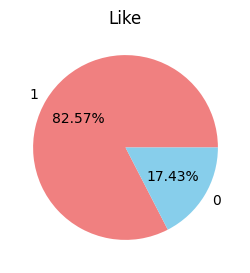

In [51]:
plt.figure(figsize=(3,3))
data['Like'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title('Like')
plt.ylabel( '' )
plt.show()

# LDA Grouping

### 1. Split every review to sentences.  

In [52]:
import re

def review_to_sentences(review):
    """
    split review into sentences contained by a list
    param: review (String)
    output: sentences (list of word)
    """
    sentences = review.splitlines()
    sentences = list(filter(None, sentences))
    tmp = []
    for sent in sentences:
        sent = re.split(r' *[\.\?!:''][\'"\)\]]* *', sent)
        tmp.extend(sent)
    # delete sentence less than specific number of words
    sentences = list(filter(lambda x:len(x.split())>=5, tmp))
    return sentences

In [53]:
list_split_sentences =  [review_to_sentences(review) for review in data["Review"]]
data["SplitReview"] = list_split_sentences
empty = [i for i, x in enumerate(data["SplitReview"]) if x ==[]] # Delete data whose splitReview is empty list
data.drop(empty, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,730,76561197969379991,1,wingman is fun with friends.,[wingman is fun with friends],,
1,730,76561198118543045,0,"Awful, toxic community and annoying game play....","[Awful, toxic community and annoying game play...",,
2,730,76561197971801273,0,After playing Counterstrike: Source for 12000+...,"[Source for 12000+ hours since 2004, something...",,
3,730,76561198123845513,0,[h1] This really doesn't have the feel of spor...,[[h1] This really doesn't have the feel of spo...,,
4,730,76561198066952727,0,too many inconsistencies to make this a good c...,[too many inconsistencies to make this a good ...,,
...,...,...,...,...,...,...,...
29981,9160,76561197992120094,0,Let me know if you can get it to work. I can't.,[Let me know if you can get it to work],,
29982,9160,76561197964009814,0,The most demonic and difficult user made level...,[The most demonic and difficult user made leve...,,
29983,9160,76561197977081885,1,"More like, Masturbator Levels of Doom 2 AMIRIT...","[More like, Masturbator Levels of Doom 2 AMIRI...",,
29984,9160,76561198010396848,1,additional levels for Doom 2.,[additional levels for Doom 2],,


avg sent:  7.038809875218033
[(1, 7307), (2, 4318), (3, 3203), (4, 2462), (5, 1787), (6, 1403), (7, 1121), (8, 986), (9, 766), (10, 680), (11, 567), (12, 472), (13, 390), (14, 360), (15, 322), (16, 286), (17, 262), (18, 271), (19, 208), (20, 225), (21, 177), (22, 170), (23, 139), (24, 139), (25, 140), (26, 100), (27, 98), (28, 95), (29, 101), (30, 90), (31, 94), (32, 79), (33, 77), (34, 66), (35, 63), (36, 64), (37, 52), (38, 63), (39, 48), (40, 49), (41, 61), (42, 53), (43, 39), (44, 31), (45, 23), (46, 30), (47, 32), (48, 14), (49, 34), (50, 33), (51, 29), (52, 20), (53, 16), (54, 15), (55, 18), (56, 14), (57, 16), (58, 11), (59, 9), (60, 14)]


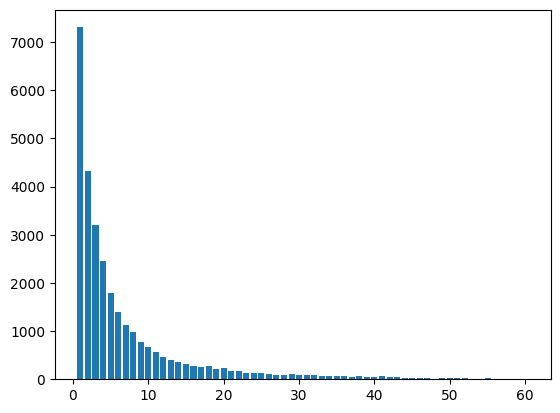

In [54]:
from collections import Counter

# Check sentence numbers distribution of reviews 
sent_num = []
for split_review in data.SplitReview:
    if len(split_review)>60:
            continue
    sent_num.append(len(split_review))
    
print("avg sent: ", sum(sent_num)/len(sent_num))
print(sorted((Counter(sent_num).items())))
plt.bar(Counter(sent_num).keys(), Counter(sent_num).values())
plt.show()

avg word:  17.24523220788563
[(4, 64), (5, 12202), (6, 12147), (7, 12256), (8, 11881), (9, 11244), (10, 10786), (11, 10731), (12, 10068), (13, 9763), (14, 9239), (15, 8936), (16, 8422), (17, 7915), (18, 7423), (19, 6964), (20, 6366), (21, 5999), (22, 5405), (23, 5129), (24, 4726), (25, 4152), (26, 3823), (27, 3533), (28, 3180), (29, 2893), (30, 2589), (31, 2481), (32, 2163), (33, 2029), (34, 1806), (35, 1550), (36, 1457), (37, 1269), (38, 1165), (39, 1009), (40, 908), (41, 851), (42, 712), (43, 677), (44, 587), (45, 557), (46, 480), (47, 464), (48, 421), (49, 383), (50, 320), (51, 301), (52, 259), (53, 257), (54, 215), (55, 204), (56, 188), (57, 175), (58, 141), (59, 128), (60, 114), (61, 86), (62, 107), (63, 90), (64, 105), (65, 82), (66, 61), (67, 70), (68, 58), (69, 53), (70, 55), (71, 45), (72, 42), (73, 33), (74, 34), (75, 31), (76, 29), (77, 26), (78, 32), (79, 41), (80, 17), (81, 22), (82, 18), (83, 19), (84, 19), (85, 13), (86, 9), (87, 14), (88, 10), (89, 8), (90, 18), (91, 10

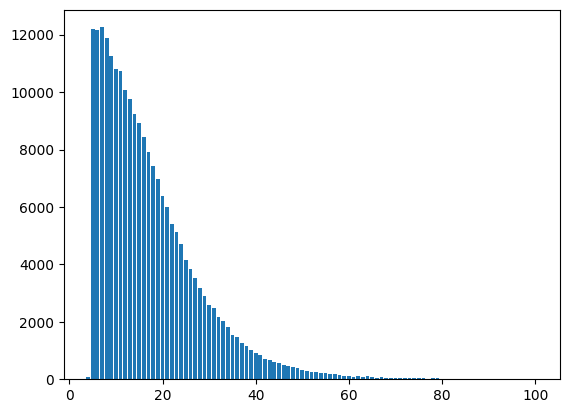

In [55]:
# Check word numbers distribution of each sent 
word_num = []
for split_review in data.SplitReview:
    for sent in split_review:
        if len(sent.split(" "))>100:
            continue
        word_num.append(len(sent.split(" ")))
print("avg word: ", sum(word_num)/len(word_num))
print(sorted((Counter(word_num).items())))
plt.bar(Counter(word_num).keys(), Counter(word_num).values())
plt.show()

avg like = 1 review:  34.95049504950495
[(0, 1), (3, 1), (5, 1), (14, 1), (15, 7), (16, 10), (17, 7), (18, 7), (19, 9), (20, 13), (21, 16), (22, 14), (23, 14), (24, 27), (25, 25), (26, 27), (27, 28), (28, 42), (29, 37), (30, 30), (31, 32), (32, 34), (33, 26), (34, 26), (35, 31), (36, 15), (37, 18), (38, 23), (39, 19), (40, 17), (41, 11), (42, 8), (43, 8), (44, 10), (45, 11), (46, 6), (47, 9), (48, 2), (49, 5), (50, 4), (51, 5), (52, 4), (53, 3), (54, 3), (55, 1), (56, 8), (57, 3), (58, 4), (59, 2), (60, 1), (61, 1), (62, 1), (63, 3), (64, 1), (65, 3), (66, 1), (67, 3), (68, 3), (69, 2), (72, 2), (73, 2), (74, 2), (75, 1), (76, 1), (78, 1), (79, 1), (83, 1), (88, 1), (90, 1), (99, 1), (100, 2), (101, 2), (105, 1), (112, 2), (129, 1), (173, 1)]


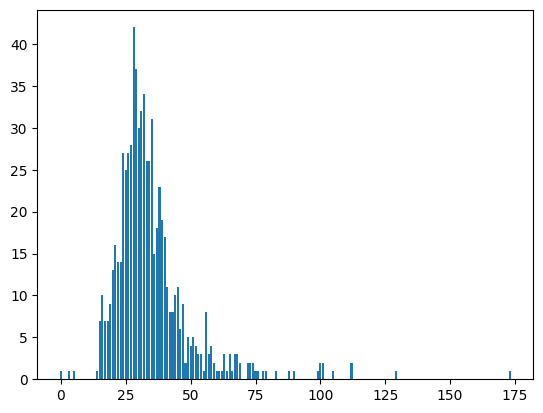

In [56]:
# Check each user's review that like = 1
user_like = []
for user in set(data["UserID"]):
    single_user_data = data[data["UserID"]==user]
    user_like.append(len(single_user_data[single_user_data["Like"]==1]))

print("avg like = 1 review: ", sum(user_like)/len(user_like))
print(sorted((Counter(user_like).items())))
plt.bar(Counter(user_like).keys(), Counter(user_like).values())
plt.show()

In [57]:
# Drop like < threshhold user
user_less_like = []
for user in set(data["UserID"]):
    single_user_data = data[data["UserID"]==user]
    if len(single_user_data[single_user_data["Like"]==1]) < 15:
        user_less_like.append(user)
        data.drop(single_user_data.index, inplace=True)
data.reset_index(drop=True, inplace=True)
user_less_like, len(data)

([76561198008114001, 76561198042590261, 76561198047366198, 76561197974603469],
 29929)

### 2. LDA Grouping
#### asign each given sentence a group

In [84]:
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer

# Modify LDA part from 趙儀
def stemmer_with_delete_stopword(split_sentences):
    vectorizer = TfidfVectorizer(stop_words = "english")
    stop_list = list(vectorizer.get_stop_words())
    stop_list += ["the", "im", "that", "but", "didnt", "it", "thi", "you", "your", "not", "doe", "did", "ive", "game", "gamer"], 
    porter_stemmer = PorterStemmer()
    all_stem_sents=[]
    for review in split_sentences:
        review_stem_list = []
        for sent in review:
            sent_stem_list =[]
            for word in sent.split(" "):
                word = re.sub(r'[^\w\s]', '', word)
                if len(word)>2 and (word not in stop_list) and (porter_stemmer.stem(word.lower()) not in stop_list):
                    sent_stem_list.append(porter_stemmer.stem(word.lower()))
            review_stem_list.append(sent_stem_list)
        all_stem_sents.append(review_stem_list) 
    return all_stem_sents

def LDAGrouping(reviews, groups):
    all_sents = []
    for review in reviews:
        for sentence in review:
            all_sents.append(sentence)
    dictionary = corpora.Dictionary(all_sents)
    corpus = [dictionary.doc2bow(sent) for sent in all_sents]
    lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=groups)
    group_results = []
    for sents in reviews:
        single_corpus = [dictionary.doc2bow(sent) for sent in sents]
        sents_group_result = []
        for scores in lda_model.inference(single_corpus)[0]:
            # scores.argmax()+1 --> Retain group:0 for no meaning sentences
            sents_group_result.append(scores.argmax()+1)
        group_results.append(sents_group_result)

    return group_results, lda_model

def pad_and_trunc(group_results, *, max_sentence):
    #max number of sentences in a review
    result_list = []
    for i, result in enumerate(group_results):
        if len(result) >= max_sentence:
            result = result[:10]
        else:
            result.extend([0]*(max_sentence-len(result)))
        result_list.append(np.array(result).astype(int))
    return result_list

In [85]:
# You can repeatly try until satisfied 
GROUPS = 7
clean_reviews = stemmer_with_delete_stopword(data["SplitReview"].tolist())
group_list, lda_model = LDAGrouping(clean_reviews, GROUPS) 
pad_group_list = pad_and_trunc(group_list, max_sentence=args["max_sentence"])
data["LDA_group"] = pad_group_list
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,730,76561197969379991,1,wingman is fun with friends.,[wingman is fun with friends],,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,730,76561198118543045,0,"Awful, toxic community and annoying game play....","[Awful, toxic community and annoying game play...",,"[5, 7, 0, 0, 0, 0, 0, 0, 0, 0]"
2,730,76561197971801273,0,After playing Counterstrike: Source for 12000+...,"[Source for 12000+ hours since 2004, something...",,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,730,76561198123845513,0,[h1] This really doesn't have the feel of spor...,[[h1] This really doesn't have the feel of spo...,,"[5, 1, 5, 4, 5, 1, 5, 4, 1, 7]"
4,730,76561198066952727,0,too many inconsistencies to make this a good c...,[too many inconsistencies to make this a good ...,,"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...
29924,9160,76561197992120094,0,Let me know if you can get it to work. I can't.,[Let me know if you can get it to work],,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
29925,9160,76561197964009814,0,The most demonic and difficult user made level...,[The most demonic and difficult user made leve...,,"[3, 5, 0, 0, 0, 0, 0, 0, 0, 0]"
29926,9160,76561197977081885,1,"More like, Masturbator Levels of Doom 2 AMIRIT...","[More like, Masturbator Levels of Doom 2 AMIRI...",,"[3, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
29927,9160,76561198010396848,1,additional levels for Doom 2.,[additional levels for Doom 2],,"[3, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [86]:
# Print topics trained from LDA
print('Topic: 0 \ndefault padding group')
for idx, topic in lda_model.show_topics(formatted=False, num_words= 30):
    print('Topic: {} \nWords: {}'.format(idx+1, '|'.join([w[0] for w in topic])))

Topic: 0 
default padding group
Topic: 1 
Words: game|play|recommend|worth|thi|classic|experi|buy|fp|like|fan|sale|love|fun|shooter|short|multiplay|seri|want|definit|enjoy|price|edit|coop|campaign|hour|secret|awesom|highli|absolut
Topic: 2 
Words: world|mission|stori|sam|gameplay|charact|seriou|atmospher|map|set|deu|lara|weird|open|explor|place|varieti|man|file|lost|monster|action|alien|effect|fairli|evil|new|chapter|battl|linear
Topic: 3 
Words: level|doom|use|enemi|time|weapon|differ|just|run|make|map|fight|game|new|design|way|gun|boss|area|difficulti|like|kill|easi|control|need|challeng|option|item|die|end
Topic: 4 
Words: game|play|review|dont|version|just|hour|music|like|know|best|steam|stori|want|ive|voic|collect|charact|make|end|thi|complet|act|main|sequel|didnt|tri|better|think|probabl
Topic: 5 
Words: game|good|like|realli|play|time|fun|just|great|feel|stori|graphic|look|pretti|bad|thi|gameplay|better|isnt|say|origin|make|lot|nice|enjoy|titl|overal|doe|thing|bit
Topic: 6 
Word

In [87]:
# Save the LDA grouping result
data.to_pickle(r"../data/filtered_review_group.pkl")

### Change user/item LDA groups (for ablation study not preprocess !!!)

In [88]:
new_lda_data = pd.read_pickle(r"../data/filtered_review_group.pkl")

In [93]:
tmp = pd.read_pickle("../data/item_emb/10130.pkl")

In [89]:
import os

for dirPath, dirNames, fileNames in os.walk("../data/item_emb/"):
    for i, file in enumerate(fileNames):
        id = int(file.split(".")[0])
        emb_path = os.path.join(dirPath, file)
        tmp = pd.read_pickle(emb_path)
        tmp["LDA_group"] = new_lda_data[new_lda_data.AppID==id]["LDA_group"]
        tmp.to_pickle(emb_path)
        print(f"{i+1}/{len(fileNames)}\r", end="")

In [90]:
import os

for dirPath, dirNames, fileNames in os.walk("../data/user_emb/"):
    for i, file in enumerate(fileNames):
        id = int(file.split(".")[0])
        emb_path = os.path.join(dirPath, file)
        tmp = pd.read_pickle(emb_path)
        tmp["LDA_group"] = new_lda_data[new_lda_data.UserID==id]["LDA_group"]
        tmp.to_pickle(emb_path)
        print(f"{i+1}/{len(fileNames)}\r", end="")

# Split Dataset

### Add imaginary negitive sample to data

In [372]:
all_app = set(data["AppID"])
all_user = set(data["UserID"])
all_neg_sample = pd.DataFrame()
for user in all_user:
    n_user_df = pd.DataFrame()
    user_data = data[data.UserID==user]
    user_interact_app = set(user_data.AppID)
    imagine_n_sample = all_app - user_interact_app
    n_user_df["AppID"] = list(imagine_n_sample)
    n_user_df["UserID"] = user
    n_user_df["Like"] = 0
    all_neg_sample = pd.concat([all_neg_sample, n_user_df])
all_neg_sample

,AppID,UserID,Like
0,17410,76561198021439491,0
1,264200,76561198021439491,0
2,460810,76561198021439491,0
3,242700,76561198021439491,0
4,34830,76561198021439491,0
...,...,...,...
396,360430,76561199081818109,0
397,248820,76561199081818109,0
398,261110,76561199081818109,0
399,782330,76561199081818109,0


In [373]:
all_pair_data = pd.concat([data, all_neg_sample])
print("Rows should match this number: ", len(set(data.UserID))*len(set(data.AppID)))
all_pair_data

Rows should match this number:  300884


,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,730,76561197969379991,1,wingman is fun with friends.,[wingman is fun with friends],,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,730,76561198118543045,0,"Awful, toxic community and annoying game play....","[Awful, toxic community and annoying game play...",,"[2, 2, 0, 0, 0, 0, 0, 0, 0, 0]"
2,730,76561197971801273,0,After playing Counterstrike: Source for 12000+...,"[Source for 12000+ hours since 2004, something...",,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,730,76561198123845513,0,[h1] This really doesn't have the feel of spor...,[[h1] This really doesn't have the feel of spo...,,"[4, 4, 5, 2, 1, 4, 4, 5, 4, 2]"
4,730,76561198066952727,0,too many inconsistencies to make this a good c...,[too many inconsistencies to make this a good ...,,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...
396,360430,76561199081818109,0,NaN,NaN,NaN,NaN
397,248820,76561199081818109,0,NaN,NaN,NaN,NaN
398,261110,76561199081818109,0,NaN,NaN,NaN,NaN
399,782330,76561199081818109,0,NaN,NaN,NaN,NaN


### Split train, val, test

In [404]:
# Split train/val/test data by user case
train_df, val_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

RANDOM_STATE = 41

for user in set(all_pair_data["UserID"]):

    user_data = all_pair_data[all_pair_data["UserID"]==user]
    user_like_data = user_data[user_data.Like == 1]
    user_unlike_data = user_data[user_data.Like == 0]

    # # Sample from each user's review that like=1 and like=0
    user_like_train, user_like_valid, user_like_test = np.split(user_like_data.sample(frac=1, random_state=RANDOM_STATE), [int(.7*len(user_like_data)), int(.8*len(user_like_data))])
    user_unlike_train, user_unlike_valid, user_unlike_test = np.split(user_unlike_data.sample(frac=1, random_state=RANDOM_STATE), [int(.7*len(user_unlike_data)), int(.8*len(user_unlike_data))])
    
    # Reduce neggative sample if you want 
    user_unlike_train_sub = user_unlike_train.sample(len(user_like_train), random_state=RANDOM_STATE)
    user_unlike_valid_sub = user_unlike_valid.sample(len(user_like_valid), random_state=RANDOM_STATE)

    user_unlike_test_1 = user_unlike_train.drop(user_unlike_train_sub.index)
    user_unlike_test_2 = user_unlike_valid.drop(user_unlike_valid_sub.index)  

    user_data_train = pd.concat([user_like_train, user_unlike_train_sub])
    user_data_val = pd.concat([user_like_valid, user_unlike_valid_sub])
    user_data_test = pd.concat([user_like_test, user_unlike_test, user_unlike_test_1, user_unlike_test_2])

    train_df = pd.concat([train_df, user_data_train], axis=0)
    val_df = pd.concat([val_df, user_data_val], axis=0)
    test_df = pd.concat([test_df, user_data_test], axis=0)

len(train_df), len(val_df), len(test_df), len(train_df)+len(val_df)+len(test_df)

(33918, 5036, 261923, 300877)

In [415]:
test_df[["AppID", "UserID", "Like"]].duplicated().any()

False

In [240]:
# Exchange negative samples in testing with positive samples in training (劉老大要求test的label都要是1)
# n_samples = len(test_df[test_df["Like"]==0])
# n_sample_test = test_df[test_df["Like"]==0]
# p_sample_train = train_df[train_df["Like"]==1].sample(n_samples)
# test_df.drop(index=n_sample_test.index, inplace=True)
# train_df.drop(index=p_sample_train.index, inplace=True)
# test_df = pd.concat([test_df, p_sample_train])
# train_df = pd.concat([train_df, n_sample_test])

# print(len(n_sample_test))
# print(len(train_df))
# print(len(test_df))

avg like = 1 review in test:  7.412517780938834
[(3, 7), (4, 46), (5, 96), (6, 164), (7, 149), (8, 92), (9, 48), (10, 26), (11, 16), (12, 18), (13, 9), (14, 9), (15, 7), (16, 3), (17, 1), (18, 2), (20, 3), (21, 3), (23, 2), (26, 1), (35, 1)]


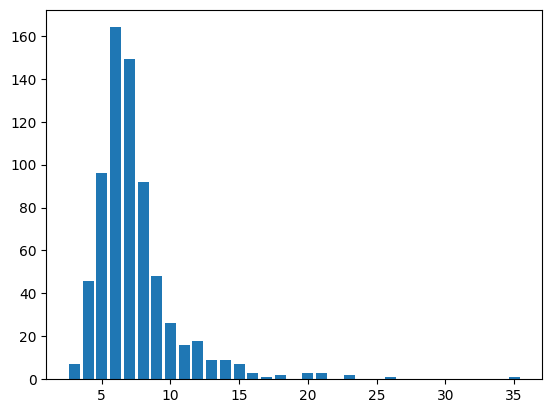

In [401]:
# Check each user's like = 1 review in test
user_like = []
for user in set(test_df["UserID"]):
    user_data = test_df[test_df["UserID"]==user]
    user_like_data = user_data[user_data.Like == 1]
    user_like.append(len(user_like_data))

print("avg like = 1 review in test: ", sum(user_like)/len(user_like))
print(sorted((Counter(user_like).items())))
plt.bar(Counter(user_like).keys(), Counter(user_like).values())
plt.show()

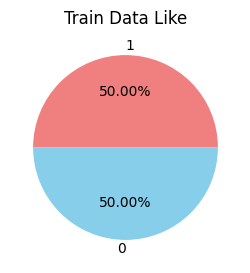

In [400]:
plt.figure(figsize=(3,3))
train_df['Like'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title('Train Data Like')
plt.ylabel( '' )
plt.show()

### Adding negitive samples to Testing data 

In [233]:
# Build the false samples of testing
# test_false_df = pd.DataFrame(columns=["AppID", "UserID", "Like"])
# app_list = []
# user_list = []
# like_list = []
# all_app = set(test_df["AppID"])
# for user in set(test_df["UserID"]):
#     user_have_item = list(test_df[test_df["UserID"]==user]["AppID"])
#     for item in all_app:
#         if (item in user_have_item) or (not train_df[(train_df["UserID"]==user) & (train_df["AppID"]==item)].empty) or (not val_df[(val_df["UserID"]==user) & (val_df["AppID"]==item)].empty):
#             continue
#         else:
#             app_list.append(item)
#             user_list.append(user)
#             like_list.append(0)
# test_false_df["AppID"] = app_list
# test_false_df["UserID"] = user_list
# test_false_df["Like"] = like_list
# test_false_df

In [234]:
# from sklearn.utils import shuffle

# Concat true and false sample into new test dataset
# test_df = pd.concat([test_df, test_false_df])
# test_df = shuffle(test_df)
# test_df.reset_index(drop=True, inplace=True)
# test_df = test_df[["UserID", "AppID", "Like"]]
# test_df

In [402]:
# Saving three types of dataframe
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df.to_pickle(r"../data/train_df.pkl")
val_df.to_pickle(r"../data/val_df.pkl")
test_df.to_pickle(r"../data/test_df.pkl")

In [353]:
# import random
# from sklearn.model_selection import train_test_split

# SEED = 21
# random.seed(SEED)

# train_ratio = 0.7
# val_ratio = 0.1
# test_ratio = 0.2

# train_app = random.sample(set(data["AppID"]), int(len(set(data["AppID"]))*train_ratio))
# test_app = list(set(data["AppID"])-set(train_app))
# val_app = random.sample(test_app, int(len(set(data["AppID"]))*val_ratio))
# test_app = list(set(test_app)-set(val_app))

# train_mask = data["AppID"].isin(train_app)
# train_df = data[train_mask]

# val_mask = data["AppID"].isin(val_app)
# val_df = data[val_mask]

# test_mask = data["AppID"].isin(test_app)
# test_df = data[test_mask]

# print(len(set(data["AppID"])))
# print(len(train_app), len(val_app), len(test_app))
# print(len(data), len(train_df)+len(val_df)+len(test_df), len(train_df), len(val_df), len(test_df))

In [354]:
# print("Train: ", len(train_df["UserID"].unique()), len(train_df["AppID"].unique())) 
# print("Val: ", len(val_df["UserID"].unique()), len(val_df["AppID"].unique())) 
# print("Test: ", len(test_df["UserID"].unique()), len(test_df["AppID"].unique())) 

# Bert Encode

### 1. Init Bert and encode methods

In [252]:
def padding_to_tagert_dimension(input_tensor, sent_len, word_len, word_dim):
    """
    Set input_tensor to specified dim with zero padding, and flatten it
    ex: [3, 25, 768] -> [10, 25, 768] -> [250, 768]
    """
    target_emb = torch.zeros(sent_len, word_len, word_dim)
    target_emb[:input_tensor.size(dim=0), :, :] = input_tensor
    target_emb = torch.flatten(target_emb, start_dim=0, end_dim=1)
    
    return target_emb

def bert_encode(review_split, args):
    """
    Encode splitted review to bert embedding
    return embedding of review padded with zero
    """
    emb_list = []
    for i, sentence in enumerate(review_split):
        if i == args["max_sentence"]: break
        sentence_encode = args["bert_tokenizer"](
            sentence,
            return_attention_mask = True,
            max_length = args["max_word"],
            truncation = True,
            padding = "max_length",
            return_tensors = 'pt'
            )
        for k,v in sentence_encode.items():
            sentence_encode[k] = v.to(args["device"])
        with torch.no_grad():
            outputs = args["bert_model"](**sentence_encode)
        sentence_emb = outputs[2][-1]
        emb_list.append(sentence_emb)
    review_emb = torch.cat(emb_list, 0)
    pad_review_emb = padding_to_tagert_dimension(review_emb, args["max_sentence"], args["max_word"], args["emb_dim"])
    return pad_review_emb

### 2. Encode splited sentences and save into multiple chunks of H5DF

In [253]:
# Saving emb for each "user"
def save_each_bert_emb(data, *, col_name, target, max_review):
    user_set_len = len(set(data[col_name]))
    for i, indie in enumerate(set(data[col_name])):
        print("執行%s進度: %d/%d\r"%(target, i+1, user_set_len), end="")
        user_data = data[data[col_name]==indie]
        for index, review in zip(user_data.index, user_data["SplitReview"]):
            review_emb = np.asarray(bert_encode(review, args))
            user_data.at[index, "SplitReview_emb"] = review_emb
            user_data[["SplitReview_emb", "LDA_group", "Like"]][:max_review].to_pickle(f'../data/{target}_emb/{indie}.pkl')

In [254]:
# This step require a lot of disk storage. Please make sure that you have sufficient space.
save_each_bert_emb(data, col_name="UserID", target="user", max_review=args["max_review_user"])

In [255]:
# This step require a lot of disk storage. Please make sure that you have sufficient space.
# Can't store all emb into one df, so it has to be run twice 
save_each_bert_emb(data, col_name="AppID", target="item", max_review=args["max_review_item"])

### 3. Show Bert Encode Result

In [256]:
tmp = pd.read_pickle(r"../data/item_emb/10150.pkl")
torch.from_numpy(np.array(tmp["SplitReview_emb"].tolist())).size()

torch.Size([50, 250, 768])

In [257]:
tmp = pd.read_pickle(r"../data/user_emb/76561199081818109.pkl")
torch.from_numpy(np.array(tmp["SplitReview_emb"].tolist())).size()

torch.Size([20, 250, 768])

# Matrix Factorization

In [4]:
mf_df = pd.read_pickle(r"../data/train_df.pkl")
mf_df = mf_df[['AppID', 'UserID', 'Like']]
mf_df['Interacted'] = 1
mf_df

,AppID,UserID,Like,Interacted
0,213610,76561198021439491,1,1
1,360,76561198021439491,1,1
2,945360,76561198021439491,1,1
3,50300,76561198021439491,1,1
4,40700,76561198021439491,1,1
...,...,...,...,...
33913,678960,76561199081818109,0,1
33914,16450,76561199081818109,0,1
33915,8930,76561199081818109,0,1
33916,332200,76561199081818109,0,1


In [5]:
from sklearn.decomposition import NMF

# Modify MF From 裴伯儀
def train_test_random_split(df):
    app_ids = list(df.columns)
    user_ids = list(df.index)
    user_set = {}
    for user_id in user_ids:
        interacted_items = [app_ids[idx] for idx in df.loc[user_id].values.nonzero()[0].tolist()]
        user_set[user_id] = interacted_items
    return user_set

def get_trainVector(df, user_set):
    business_ids = list(df.columns)
    user_ids = list(df.index)
    return [ [1 if business_id in user_set[user_id] else 0 for business_id in business_ids ] for user_id in user_ids]

def matrix_factorization(matrix, trainVector):
    # n_components is embedding dimension, vervose=1 shows the training process
    model = NMF(n_components=128, init='random', random_state=0, verbose=0, max_iter=400)
    user_embeddings = model.fit_transform(trainVector)
    encoded_user_embeddings = np.asarray(user_embeddings, dtype=np.float32)
    app_embeddings = model.components_.T
    encoded_app_embeddings = np.asarray(app_embeddings, dtype=np.float32)
    user_id_emb = dict(zip(matrix.index, encoded_user_embeddings))
    app_id_emb = dict(zip(matrix.columns, encoded_app_embeddings))

    predicted_rating_matrix = user_embeddings.dot(app_embeddings.T)
    predicted_rating_matrix = predicted_rating_matrix-trainVector # Mask prediction that is in train set
    predicted_rating_matrix[predicted_rating_matrix<0]=0 
    
    return user_id_emb, app_id_emb, predicted_rating_matrix

### Construct Rating Matrix and Interaction Matrix

In [6]:
interaction_matrix = mf_df.pivot_table(index='UserID', columns='AppID', values='Interacted').fillna(0)
rating_matrix = mf_df.pivot_table(index='UserID', columns='AppID', values='Like').fillna(0)

### Train MF Model

In [7]:
user_id_emb, app_id_emb, mf_predicted_rating_matrix = matrix_factorization(rating_matrix, interaction_matrix)
len(user_id_emb), len(app_id_emb), next(iter(user_id_emb.values())).shape, next(iter(app_id_emb.values())).shape, mf_predicted_rating_matrix.shape

(703, 428, (128,), (128,), (703, 428))

In [9]:
top_k_list = [10, 5]
mf_top_k_df = mf_predicted_rating_matrix.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=max(top_k_list))
mf_top_k_df

,0,1,2,3,4,5,6,7,8,9
UserID,,,,,,,,,,
76561197960319772,8000,252410,266510,391540,1245620,739630,12210,535930,2360,225320
76561197960420790,115100,435150,739630,234190,1092790,108600,222480,870780,215530,391540
76561197960425408,22350,247080,107310,2210,266840,860510,214770,32460,558420,323320
76561197960440071,50130,4500,107310,550,13600,45740,214340,999220,215530,225160
76561197960458021,107310,34870,860510,2620,15190,266840,3730,3480,214340,1549970
...,...,...,...,...,...,...,...,...,...,...
76561198989051349,263980,648800,22000,320,3730,237630,299030,9050,50130,227300
76561198998262497,9050,435150,1300,252410,3730,215530,620,612880,614570,501590
76561199057481492,261030,9050,400,1245620,614570,50620,462780,501590,2290,12220


### Save MF Embedding

In [286]:
app_mf_df = pd.DataFrame()
app_mf_df["AppID"] = list(app_id_emb.keys())
app_mf_df["MF_emb"] = list(app_id_emb.values())
app_mf_df.to_pickle(r"../data/train_item_mf_emb.pkl")

user_mf_df = pd.DataFrame()
user_mf_df["UserID"] = list(user_id_emb.keys())
user_mf_df["MF_emb"] = list(user_id_emb.values())
user_mf_df.to_pickle(r"../data/train_user_mf_emb.pkl")

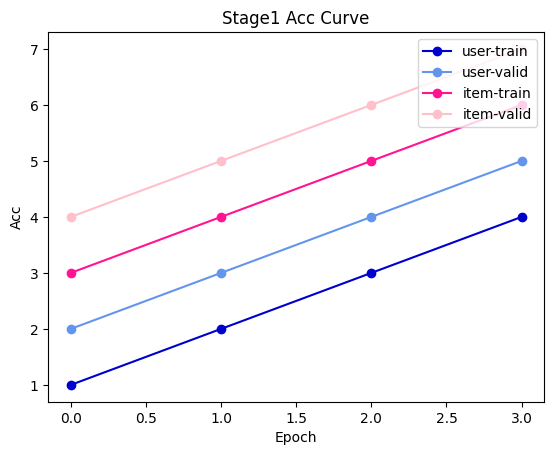

In [287]:
import matplotlib.pyplot as plt

t1 = [1,2,3,4]
v1 = [2,3,4,5]
t2 = [3,4,5,6]
v2 = [4,5,6,7]

# Plot test
def draw_acc_curve_stage1(u_train_acc, u_valid_acc, i_train_acc, i_valid_acc):
    plt.plot(u_train_acc, color="mediumblue", label="user-train", marker='o')
    plt.plot(u_valid_acc, color="cornflowerblue", label="user-valid", marker='o')
    plt.plot(i_train_acc, color="deeppink", label="item-train", marker='o')
    plt.plot(i_valid_acc, color="pink", label="item-valid", marker='o')
    plt.legend(loc="upper right")
    plt.xlabel("Epoch")
    plt.ylabel("Acc")
    plt.title(f"Stage1 Acc Curve")
    plt.show()

draw_acc_curve_stage1(t1,v1, t2, v2)

# Test multiple result for ablation research (NOT for preprocess)

In [12]:
review_df = pd.read_pickle("../data/test_df.pkl")

def get_empty_incidence_df():
    user_index = set(review_df["UserID"])
    app_index = set(review_df["AppID"])
    incidence_df = pd.DataFrame(index=set(user_index), columns=set(app_index), dtype=np.float32)
    incidence_df.fillna(0, inplace=True)
    incidence_df.sort_index(inplace=True)
    incidence_df = incidence_df.reindex(sorted(incidence_df.columns), axis=1)
    return incidence_df

def get_true_incidence_df():
    user_index = set(review_df["UserID"])
    incidence_df = get_empty_incidence_df()
    for user in user_index:
        user_df = review_df[review_df["UserID"]==user]
        user_like_app_list = list(user_df[user_df["Like"]==1]["AppID"])
        incidence_df.at[user, user_like_app_list] = 1

    # pivot_df = review_df.pivot_table(values="Like", index="UserID", columns="AppID")
    # pivot_df[np.isnan(pivot_df)] = 0
    
    return incidence_df

label_incidence_df = get_true_incidence_df()
label_incidence_df

,20,30,40,60,320,360,400,420,500,550,...,1233570,1237970,1238060,1245620,1252330,1259420,1282730,1332010,1549970,1794680
76561197960319772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960420790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960425408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960440071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960458021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76561198989051349,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561198998262497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561199057481492,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561199081818109,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, ndcg_score, average_precision_score
import math
import time

# adjust TOP_N to see different result
TOP_N = 5

def ndcg(y_true, y_pred, top_K=0):
    # From 趙儀
    ndcg_K = []
    true_sum = 0

    for i in range(y_pred.shape[0]):
        top_indices = y_pred[i].argsort()[-top_K:][::-1] #每篇文章排名前Top K可能的tag index
        true_num = np.sum(y_true[i, :])
        true_sum += true_num
        dcg = 0
        idcg = 0
        idcgCount = true_num
        j = 0
        for item in top_indices:
            if y_true[i, item] == 1:
                dcg += 1.0/math.log2(j + 2)
            if idcgCount > 0:
                idcg += 1.0/math.log2(j + 2)
                idcgCount = idcgCount-1
            j += 1
        if(idcg != 0):
            ndcg_K.append(dcg/idcg)

    return  np.mean(np.array(ndcg_K))

def apk(actual, predicted, k):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 1.0

    return score / min(len(actual), k)

def topk_score(predict_incidence_df, top_k_df, top_k_list):

    # Calculate each score
    for top_k in top_k_list:

        hit_n = []
        global_labels = []
        global_prediction = []

        for user in predict_incidence_df.index:
            
            # Data for scoring
            user_topk_prediction = top_k_df.loc[user]
            user_pred_prob = predict_incidence_df.loc[user]
            
            user_label = label_incidence_df.loc[user]
            user_like = user_label[user_label==1].keys()
            user_topk_label = label_incidence_df.loc[user, user_topk_prediction]

            # get 01 prediction from probability
            pred_tensor = torch.tensor(user_pred_prob.values)
            value, idx = pred_tensor.topk(k=top_k)
            user_pred_binary = torch.zeros(pred_tensor.size())
            user_pred_binary[idx] = 1 

            global_labels.append(user_label.tolist())
            global_prediction.append(user_pred_binary.tolist())

            # Top-10 hit ratio
            user_top_n_label = user_topk_label[:top_k]
            if len(user_top_n_label[user_top_n_label==1]) > 0:
                hit_n.append(1)
            else:
                hit_n.append(0)


        test_precision = precision_score(global_labels, global_prediction, zero_division=0, average="samples")
        test_recall = recall_score(global_labels, global_prediction, zero_division=0, average="samples")
        test_f1 = f1_score(global_labels, global_prediction, zero_division=0, average="samples")

        test_hit_n = sum(hit_n) / len(hit_n)

        # MAP@K, NDCG@K 聖偉
        trueidlist = [np.where(i==1)[0].tolist() for i in label_incidence_df.to_numpy()]
        predidorder = np.flip(predict_incidence_df.to_numpy().argsort()[:,-top_k:], axis=1)
        test_map = np.mean([apk(a, p, top_k) for a, p in zip(trueidlist, predidorder)])

        # test_map = average_precision_score(label_incidence_df.to_numpy(), predict_incidence_df.to_numpy(), average="samples")
        test_ndcg = ndcg(label_incidence_df.to_numpy(), predict_incidence_df.to_numpy(), top_k)

        print(f"[ Test collab ] precision@{top_k} = {test_precision:.4f}, recall@{top_k} = {test_recall:.4f}, f1@{top_k} = {test_f1:.4f}")
        print(f"[ Test collab ] MAP@{top_k} = {test_map:.4f}, NDCG@{top_k} = {test_ndcg:.4f}, HR@{top_k} = {test_hit_n:.4f}")
        print("----------------------------------------------------------------------")

In [36]:
# MF topk result
predict_incidence_df = mf_predicted_rating_matrix
top_k_df = mf_top_k_df
top_k_list = [10, 7, 5]
topk_score(mf_predicted_rating_matrix, mf_top_k_df, top_k_list)

[ Test collab ] precision@10 = 0.0364, recall@10 = 0.0508, f1@10 = 0.0413
[ Test collab ] MAP@10 = 0.0188, NDCG@10 = 0.0486, HR@10 = 0.3087
----------------------------------------------------------------------
[ Test collab ] precision@7 = 0.0372, recall@7 = 0.0361, f1@7 = 0.0356
[ Test collab ] MAP@7 = 0.0186, NDCG@7 = 0.0429, HR@7 = 0.2319
----------------------------------------------------------------------
[ Test collab ] precision@5 = 0.0401, recall@5 = 0.0281, f1@5 = 0.0320
[ Test collab ] MAP@5 = 0.0215, NDCG@5 = 0.0431, HR@5 = 0.1849
----------------------------------------------------------------------


In [33]:
predict_incidence_df = pd.read_pickle('output/history/collab_aspect_mf_0.4_7g_stage2_only/collab_probability_df.pkl')
top_k_df = pd.read_pickle('output/history/collab_aspect_mf_0.4_7g_stage2_only/collab_topk_prediction_df.pkl')
top_k_list = [5, 7, 10]
topk_score(predict_incidence_df, top_k_df, top_k_list)

[ Test collab ] precision@5 = 0.0472, recall@5 = 0.0318, f1@5 = 0.0370
[ Test collab ] MAP@5 = 0.0139, NDCG@5 = 0.0437, HR@5 = 0.2091
----------------------------------------------------------------------
[ Test collab ] precision@7 = 0.0471, recall@7 = 0.0446, f1@7 = 0.0445
[ Test collab ] MAP@7 = 0.0164, NDCG@7 = 0.0466, HR@7 = 0.2788
----------------------------------------------------------------------
[ Test collab ] precision@10 = 0.0465, recall@10 = 0.0626, f1@10 = 0.0518
[ Test collab ] MAP@10 = 0.0194, NDCG@10 = 0.0543, HR@10 = 0.3656
----------------------------------------------------------------------
